In [1]:
#bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
#import holidays
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
#definir o diretório
os.chdir(os.getcwd()[:-9])

In [3]:
#importar dataset
df = pd.read_parquet("data/processed/df_vendas.parquet")
df.data = pd.to_datetime(df.data, format="%d/%m/%Y")

In [4]:
#conhecendo o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147414 entries, 0 to 147413
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   cfop           147414 non-null  int64         
 1   nnf            147414 non-null  int64         
 2   codfil         147414 non-null  int64         
 3   xnomeemit      147414 non-null  object        
 4   xfantemit      147414 non-null  object        
 5   cnpjdest       147414 non-null  int64         
 6   xmun           147414 non-null  object        
 7   cod            147414 non-null  float64       
 8   seqprod        147414 non-null  int64         
 9   xprod          147414 non-null  object        
 10  tipo           147414 non-null  object        
 11  qcom           147414 non-null  float64       
 12  ucom           147414 non-null  object        
 13  ano            147414 non-null  int64         
 14  mes            147414 non-null  int64         
 15  

In [5]:
# Contar a quantidade de NA
df.isna().sum()

cfop                 0
nnf                  0
codfil               0
xnomeemit            0
xfantemit            0
cnpjdest             0
xmun                 0
cod                  0
seqprod              0
xprod                0
tipo                 0
qcom                 0
ucom                 0
ano                  0
mes                  0
nome_correto         0
cod_ibge             0
nome_oficial         0
uf_oficial           0
data                 0
VlCusteio          240
AreCusteio         240
preco_feijao     22870
preco_laranja    22870
preco_trigo      22870
preco_soja           0
preco_milho          0
dtype: int64

In [17]:
df_grupo = df.groupby(["ano", "cod"])["qcom"].sum().sort_index().sort_values()

df_grupo

ano   cod       
2025  30028.0357        1.0
      30028.0425        1.0
      30028.0299        1.0
      30028.0298        1.0
      30026.0097        1.0
                     ...   
2020  30028.0095    13621.0
2021  30028.0066    13931.0
2024  30028.0327    14048.0
2022  30028.0095    14546.0
2023  30028.0095    15225.0
Name: qcom, Length: 792, dtype: float64

In [18]:
#Numero de produtos e quantidade de dias de venda
len(df.cod.unique()), len(df.data.unique())

(244, 66)

In [7]:
# Primeira e ultima data
df.data.min(), df.data.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2025-06-01 00:00:00'))

<positron-console-cell-8>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


<Axes: title={'center': 'Total de vendas por mês'}, xlabel='data'>

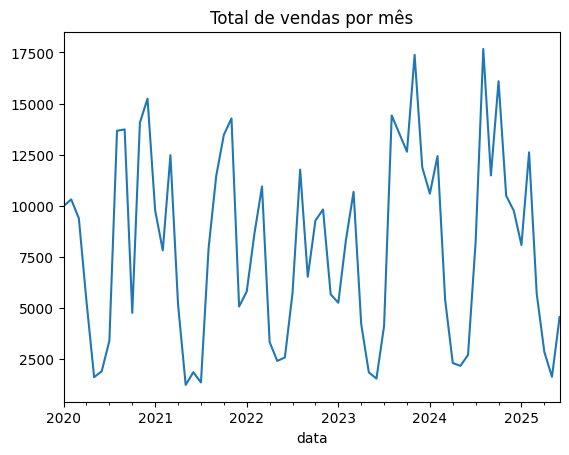

In [8]:
# Observar a continuidade dos dados
df.set_index("data").resample("M")["qcom"].sum().plot(title="Total de vendas por mês")

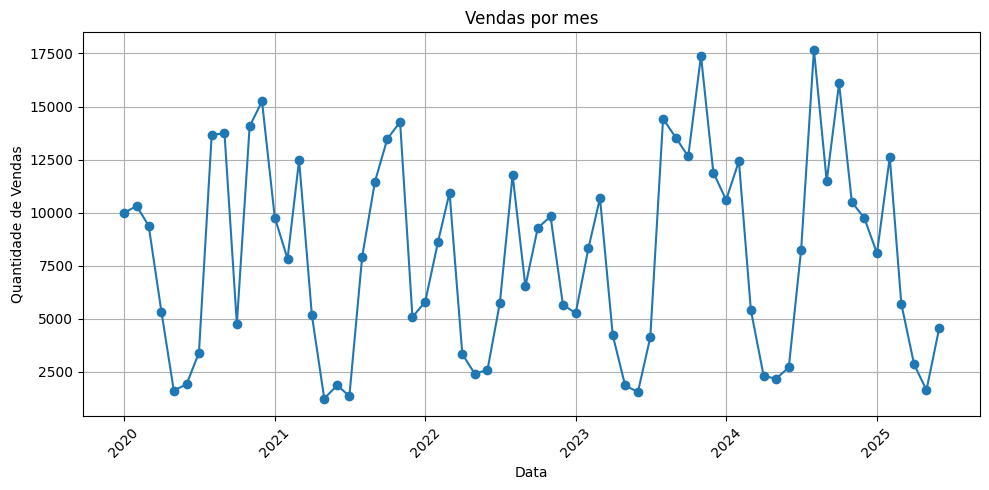

In [11]:
# Agrupar por data e somar as vendas
vendas_mensal = df.groupby(df["data"].dt.to_period("M"))["qcom"].sum().reset_index()

# Converter de volta para datetime para plotar
vendas_mensal['data'] = vendas_mensal['data'].dt.start_time

# Plotar o gráfico
plt.figure(figsize=(10, 5))
plt.plot(vendas_mensal['data'], vendas_mensal['qcom'], marker='o')
plt.title('Vendas por mes')
plt.xlabel('Data')
plt.ylabel('Quantidade de Vendas')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# descrições dos produtos mais vendidos
df.groupby("cod")["qcom"].describe().sort_values(["count","mean"], ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
30028.0095,14957.0,4.010898,11.578110,1.0,1.0,1.0,3.0,864.0
30028.0066,11936.0,3.577916,7.528822,1.0,1.0,2.0,3.0,250.0
30028.0202,4244.0,3.086004,5.117788,1.0,1.0,2.0,3.0,108.0
30028.0101,3886.0,3.143592,6.236396,1.0,1.0,2.0,3.0,220.0
30028.0175,3773.0,3.946462,6.579701,1.0,1.0,2.0,4.0,152.0


In [24]:
# descrições dos produtos menos vendidos
df.groupby("cod")["qcom"].describe().sort_values(["count","mean"], ascending=False).tail()

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
30028.0216,1.0,25.0,NaN,25.0,25.0,25.0,25.0,25.0
30028.0058,1.0,19.0,NaN,19.0,19.0,19.0,19.0,19.0
30026.0070,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
30026.0148,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
30026.0037,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0


### Criar cluster 

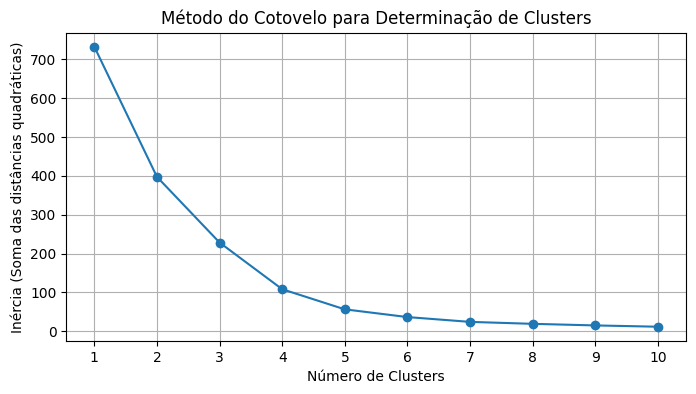

In [59]:
# Criar features agregadas para cada produto
product_features = df.groupby('cod').agg({
    'qcom': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

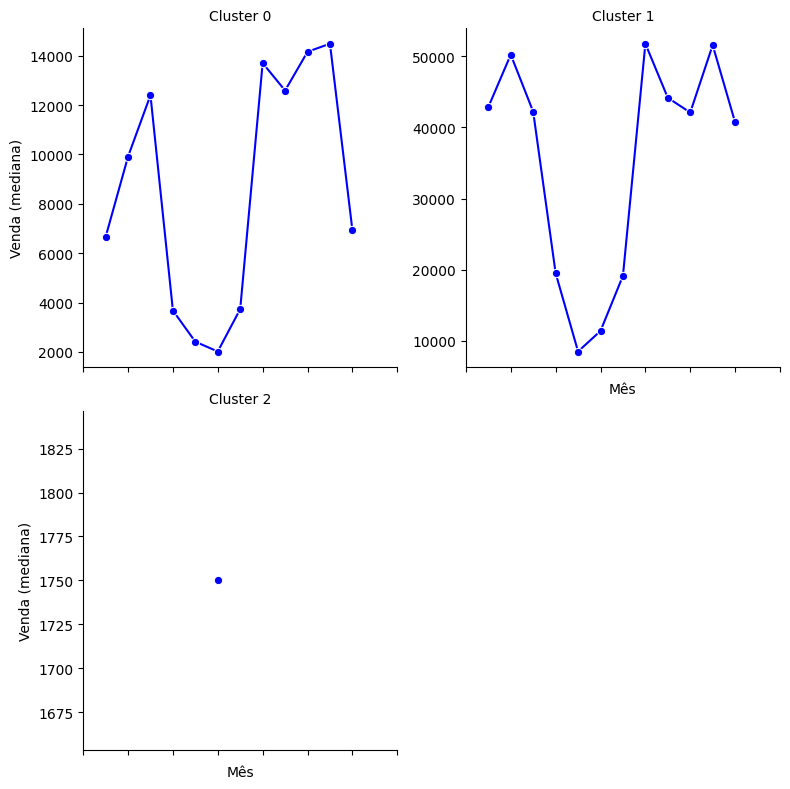

In [62]:
# Clusterização final
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(product_features_scaled)

# Mapear os clusters de volta para o DataFrame original
# (Assumindo que 'product_features' tem o mesmo índice que 'df['sku']')
df['cluster_cod'] = df['cod'].map(dict(zip(product_features.index, clusters)))

# Agrupar por semana e cluster, calculando a mediana das vendas
#df["semana"] = df["data"].dt.to_period("M").astype(str)  # Convertendo para string para melhor visualização
df_cluster = df.groupby(["mes", "cluster_cod"])["qcom"].sum().reset_index()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_cluster, col='cluster_cod', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='mes', y='qcom', marker='o', color='b')  # Adicionando cor fixa para consistência
g.set_titles("Cluster {col_name}")
g.set_xticklabels(rotation=45)  # Rotacionar rótulos do eixo x
g.set_axis_labels("Mês", "Venda (mediana)")  # Nomes dos eixos
g.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

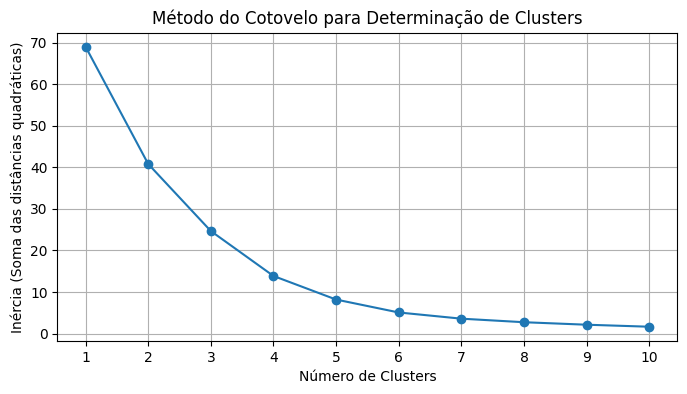

In [24]:
# Criar features agregadas para cada produto
product_features = df.groupby('xfantemit').agg({
    'qcom': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

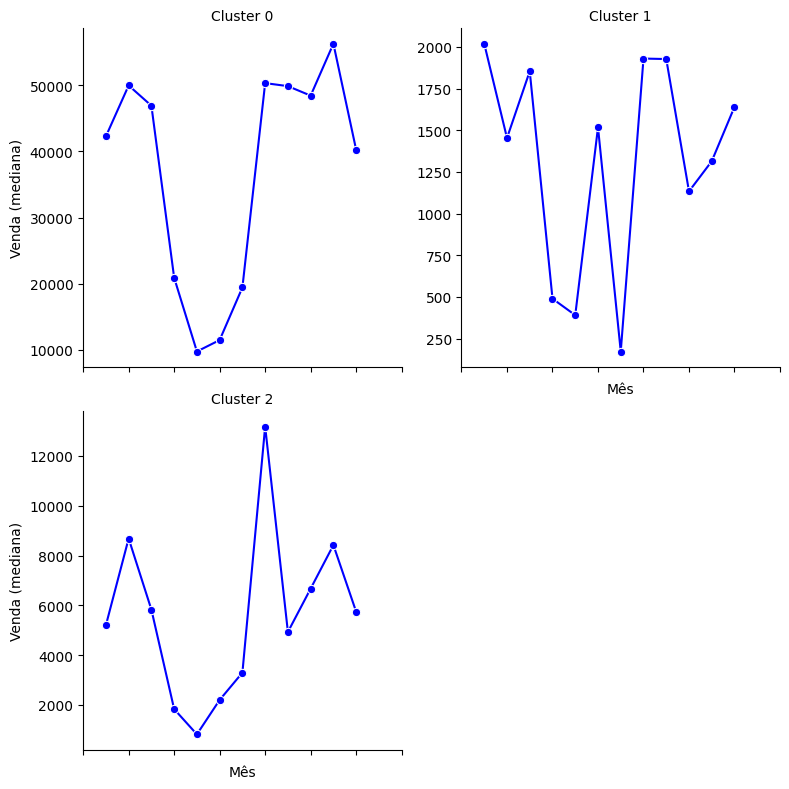

In [25]:
# Clusterização final
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(product_features_scaled)

# Mapear os clusters de volta para o DataFrame original
# (Assumindo que 'product_features' tem o mesmo índice que 'df['sku']')
df['cluster'] = df['xfantemit'].map(dict(zip(product_features.index, clusters)))

# Agrupar por semana e cluster, calculando a mediana das vendas
#df["semana"] = df["data"].dt.to_period("M").astype(str)  # Convertendo para string para melhor visualização
df_cluster = df.groupby(["mes", "cluster"])["qcom"].sum().reset_index()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_cluster, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='mes', y='qcom', marker='o', color='b')  # Adicionando cor fixa para consistência
g.set_titles("Cluster {col_name}")
g.set_xticklabels(rotation=45)  # Rotacionar rótulos do eixo x
g.set_axis_labels("Mês", "Venda (mediana)")  # Nomes dos eixos
g.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

## Features temporais

In [17]:
df.tipo.unique()

array(['FUNGICIDAS', 'HERBICIDAS', 'FUNGICIDAS BIOLOGICOS'], dtype=object)

<Axes: xlabel='ano', ylabel='qcom'>

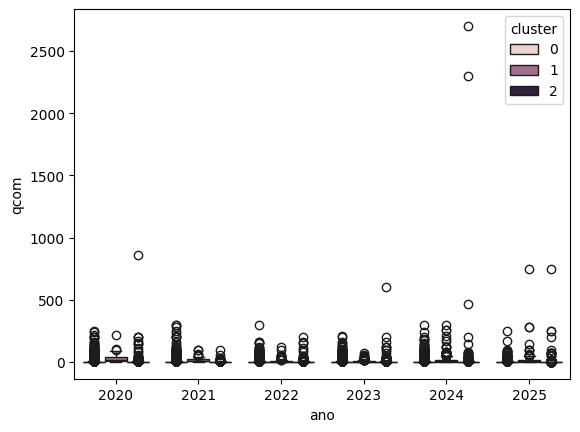

In [27]:
# Boxplot das vendas em cada dia da semana para cada cluster
sns.boxplot(x="ano", y="qcom", hue="cluster", data=df)

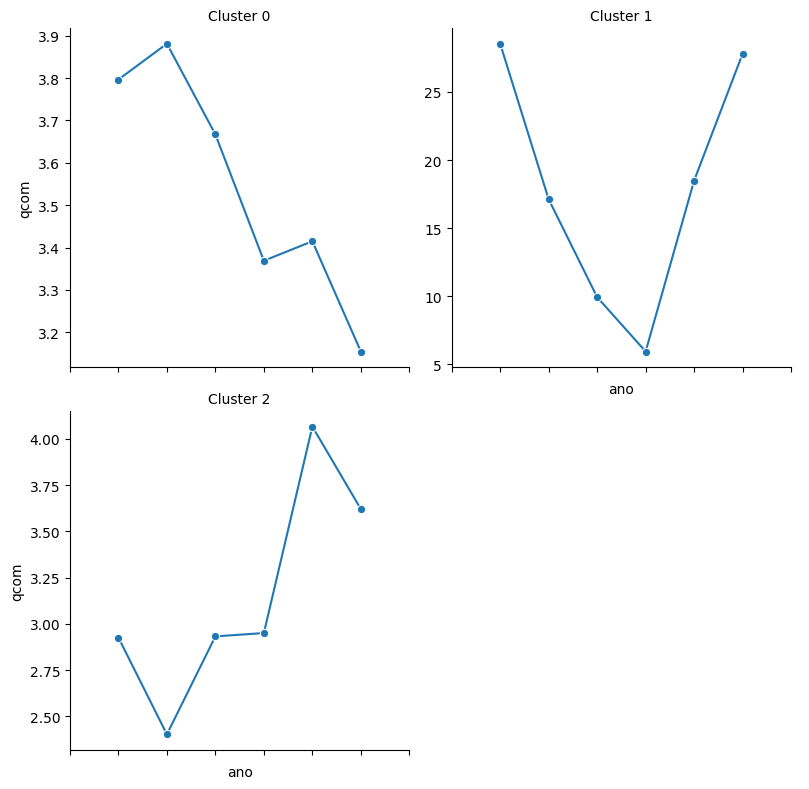

In [28]:
# Agrupar média de vendas por produto e dia da semana
df_grouped = df.groupby(["ano", "cluster"], as_index=False)["qcom"].mean()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_grouped, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="ano", y='qcom', marker='o')
g.set_titles("Cluster {col_name}")
g.set_xticklabels()
g.add_legend()
plt.tight_layout()
plt.show()

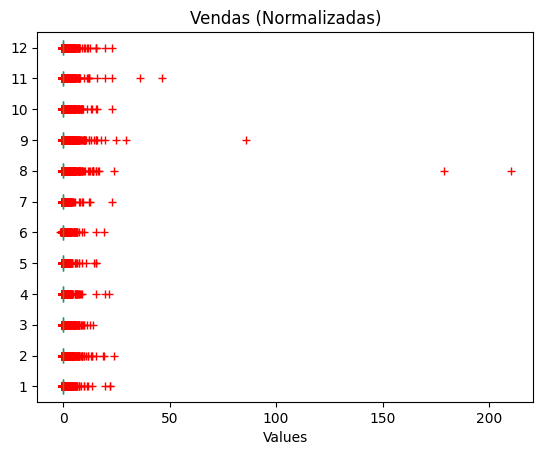

In [24]:
#Normalizando os dados para criar boxplot das variáveis númericas
sca = preprocessing.StandardScaler()
df["venda_scaled"] = df.groupby("cluster")["qcom"].transform(lambda x: sca.fit_transform(x.values.reshape(-1, 1)).flatten())

df_pivot = df.pivot(columns="mes", values="venda_scaled").fillna(0)
#df_pivot.columns = ["segunda", "terça", "quarta", "quinta", "sexta", "sábado", "domingo"]

# Criar os plots
fig, ax = plt.subplots()
box = df_pivot.plot(kind="box", vert=False, sym="r+", patch_artist=True, ax=ax)

# Definir rótulos
plt.xlabel("Values")
plt.title("Vendas (Normalizadas)")

# Remover grades
plt.grid(False)

# Exibir o gráfico
plt.show()

C:\Users\auxil\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


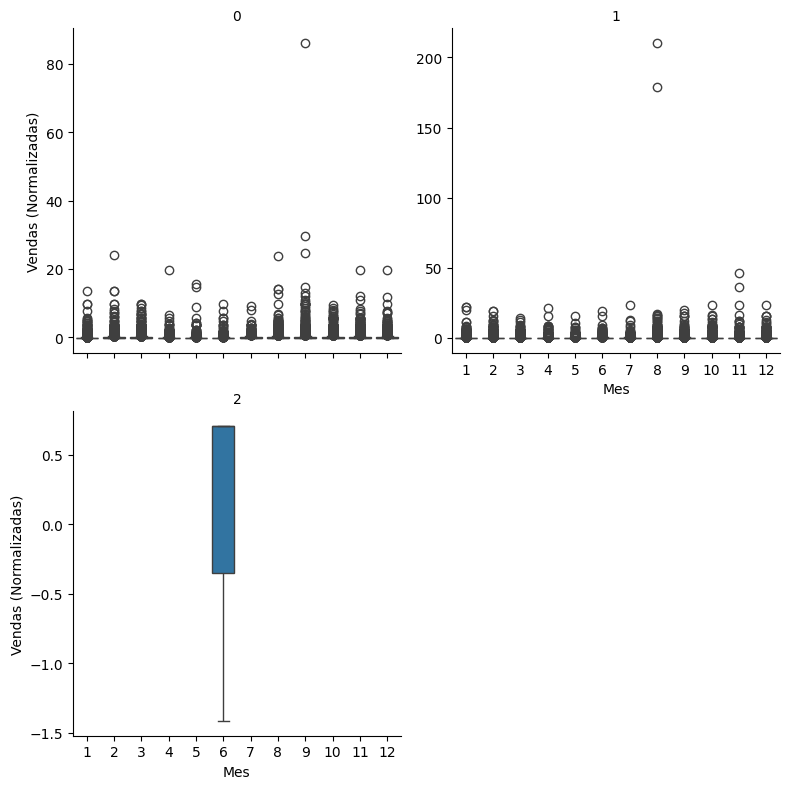

In [25]:
#Normalizando os dados para criar boxplot das variáveis númericas
sca = preprocessing.StandardScaler()
df["venda_scaled"] = df.groupby("cluster")["qcom"].transform(lambda x: sca.fit_transform(x.values.reshape(-1, 1)).flatten())

# FacetGrid: Boxplot de vendas por dia da semana, por produto
g = sns.FacetGrid(df, col="cluster", col_wrap=2, height=4, sharey=False)
g.map(sns.boxplot, "mes", "venda_scaled")
g.set_titles("{col_name}")
g.set_axis_labels("Mes", "Vendas (Normalizadas)")
plt.tight_layout()
plt.show()

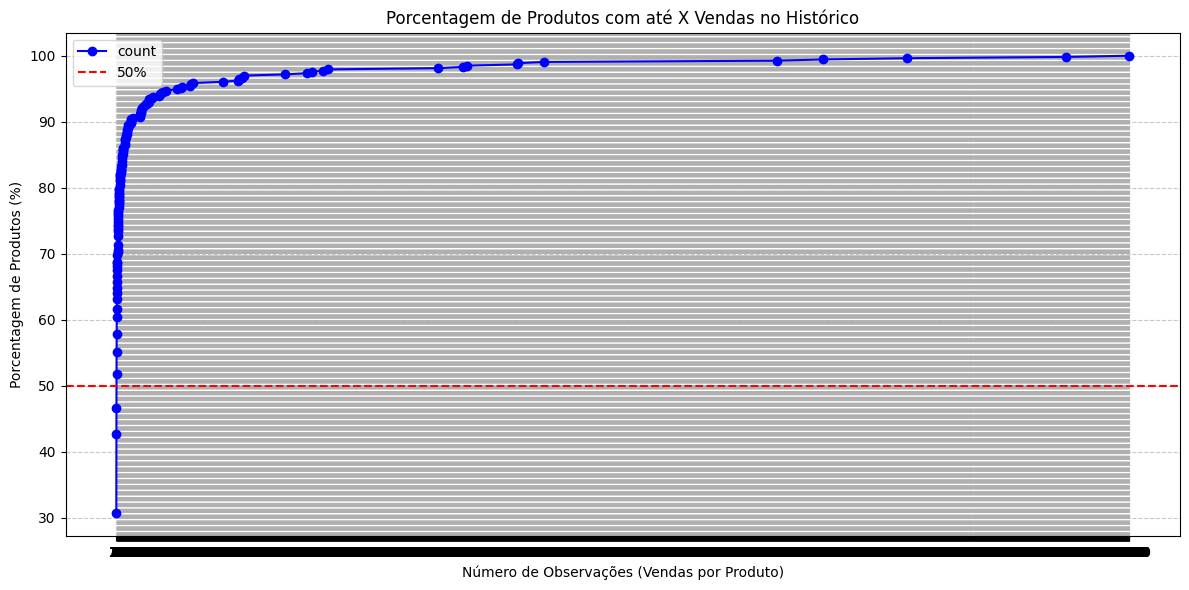

In [29]:
# 1. Calcular o número de observações (vendas) por produto
vendas_por_produto = df.groupby(['qcom', "mes"]).size().sort_values()

# 2. Calcular a porcentagem acumulada de produtos com até X observações
# Exemplo: Qual % de produtos tem <= 10 vendas?
total_produtos = len(vendas_por_produto)  # Substitui 5696 pelo total real
porcentagem_acumulada = (vendas_por_produto.value_counts().sort_index().cumsum() / total_produtos * 100)

# 3. Plotar o gráfico
plt.figure(figsize=(12, 6))
porcentagem_acumulada.plot(kind='line', marker='o', linestyle='-', color='b')
# Personalizar eixo x
max_obs = vendas_por_produto.max()
plt.xticks(np.arange(0, max_obs + 1, 5))  # Intervalo de 5 em 5
plt.xlabel('Número de Observações (Vendas por Produto)')
plt.ylabel('Porcentagem de Produtos (%)')
plt.title('Porcentagem de Produtos com até X Vendas no Histórico')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', label='50%')  # Linha de referência
plt.legend()
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Distribuição de tamanho da série por produto'}>

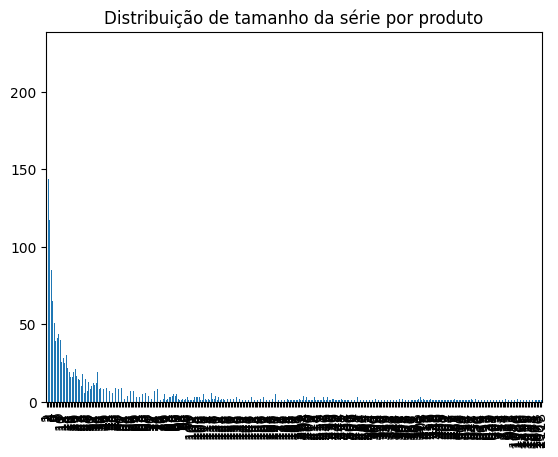

In [30]:
#Ver quantos produtos têm histórico curto
df.groupby(["cod", "mes"]).size().value_counts().sort_index().plot(kind="bar", title="Distribuição de tamanho da série por produto")

### Teste de inferência estatística

In [31]:
# ANOVA para testar a diferença de média entre mes
# Criar listas separadas por mes
grupo_1 = df[df['mes'] == 1]['qcom']
grupo_2 = df[df['mes'] == 2]['qcom']
grupo_3 = df[df['mes'] == 3]['qcom']
grupo_4 = df[df['mes'] == 4]['qcom']
grupo_5 = df[df['mes'] == 5]['qcom']
grupo_6 = df[df['mes'] == 6]['qcom']
grupo_7 = df[df['mes'] == 7]['qcom']
grupo_8 = df[df['mes'] == 8]['qcom']
grupo_9 = df[df['mes'] == 9]['qcom']
grupo_10 = df[df['mes'] == 10]['qcom']
grupo_11 = df[df['mes'] == 11]['qcom']
grupo_12 = df[df['mes'] == 12]['qcom']

# Como estamos comparando média entre mais de dois grupos (P, M, G). Teste mais adequado é ANOVA (análise de variância).
f_stat, p_val = f_oneway(grupo_1, grupo_2, grupo_3,
                         grupo_4, grupo_5, grupo_6, grupo_7,
                         grupo_8, grupo_9, grupo_10, grupo_11,
                         grupo_12)

# Se p_val < 0.05, existe diferença estatística entre pelo menos dois grupos.
print(f'Estatística F: {f_stat}')
print(f'p-valor{p_val}')

Estatística F: 16.188190466093328
p-valor2.691818388258884e-32


In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Se a ANOVA der p < 0.05, você deve rodar um Tukey HSD para saber quais pares de tamanhos são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df['qcom'], groups=df['mes'], alpha=0.05)

print(tukey_result.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.2192 0.9079 -0.2271  0.6654  False
     1      3   0.4811 0.0356  0.0154  0.9467   True
     1      4   0.4143  0.513 -0.1875  1.0161  False
     1      5   0.8006 0.0817 -0.0427   1.644  False
     1      6    2.092    0.0  1.2625  2.9214   True
     1      7   0.6544 0.0277  0.0348   1.274   True
     1      8    1.163    0.0  0.6979  1.6281   True
     1      9   1.2098    0.0  0.7253  1.6942   True
     1     10   0.4994 0.0215  0.0367  0.9622   True
     1     11   0.3584 0.2484 -0.0825  0.7994  False
     1     12   0.1898 0.9775 -0.2821  0.6616  False
     2      3   0.2619 0.7639 -0.1902   0.714  False
     2      4   0.1952 0.9956 -0.3962  0.7865  False
     2      5   0.5815  0.496 -0.2545  1.4174  False
     2      6   1.8728    0.0  1.0509  2.6947   True
     2      7   0.4352 0.4523 -0.1743  1.0447 

In [35]:
# Tukey HSD para saber quais pares de final de semana x dia útil são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df['qcom'], groups=df['tipo'], alpha=0.05)

print(tukey_result.summary())

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1                group2        meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------
           FUNGICIDAS FUNGICIDAS BIOLOGICOS   1.4595 0.1863 -0.4937 3.4127  False
           FUNGICIDAS            HERBICIDAS   0.6666    0.0  0.4852  0.848   True
FUNGICIDAS BIOLOGICOS            HERBICIDAS  -0.7929 0.6063 -2.7417 1.1559  False
---------------------------------------------------------------------------------


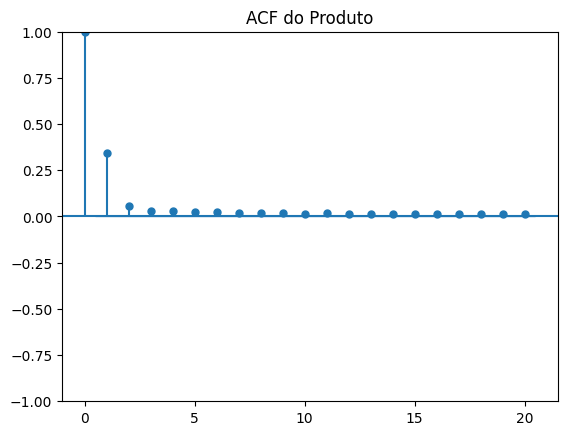

In [35]:
# Mais de 50% dos produtos têm menos de 12 registros históricos, isso indica que sua série temporal 
# pode ser esparsa (muitos produtos com poucas observações). Nesse caso, a análise de autocorrelação
# para produtos com +12 registros

# Filtrar produtos com +12 registros
#produtos_validos = df['qcom'].value_counts()[df['qcom'].value_counts() > 12].index
#df_filtrado = df[df['qcom'].isin(produtos_validos)]

# Calcular ACF para um produto específico (ex.: primeiro da lista)
#produto_exemplo = produtos_validos[0]
ts_produto = df.set_index('data')['qcom'].sort_index()

plot_acf(ts_produto, lags=min(20, len(ts_produto)-1), alpha=0.05)
plt.title(f'ACF do Produto')
plt.show()

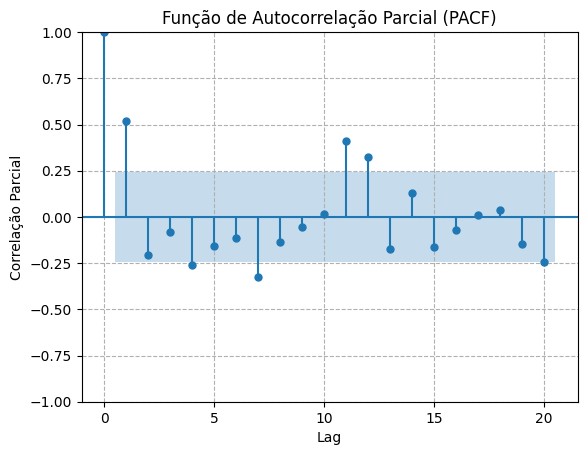

In [34]:
# Agrupar por data e somar vendas (caso haja múltiplos produtos)
ts_vendas = df.groupby('data')['qcom'].sum().sort_index()

# Plotar PACF (substitua ts_vendas por ts_produto se necessário)
plot_pacf(ts_vendas, lags=20, alpha=0.05, method='ols')  # alpha=0.05 → 95% confiança
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlação Parcial')
plt.grid(linestyle='--')
plt.show()

In [36]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
filiais = df.groupby(["codfil"])["qcom"].sum().sort_values(ascending=False).head()
df[df.codfil.isin(filiais.index.to_list())]

In [39]:
# Agregação mensal
df["mes_ano"] = df.data.dt.to_period("M")

# "cod_ibge", " "codfil", "cod"
df_m = df.groupby(["cod_ibge", "mes_ano", "codfil", "cod"]).agg(
    quant_vendida = ("qcom", "sum"),
    valor_custeio = ("VlCusteio", "mean"),
    area_custeio = ("AreCusteio", "mean"),
    preco_feijao = ("preco_feijao", "mean"),
    preco_laranja = ("preco_laranja", "mean"),
    preco_trigo = ("preco_trigo", "mean"),
    preco_soja = ("preco_soja", "mean"),
    preco_milho = ("preco_milho", "mean")
).reset_index().set_index("mes_ano").sort_index()

ts = df_m["quant_vendida"]


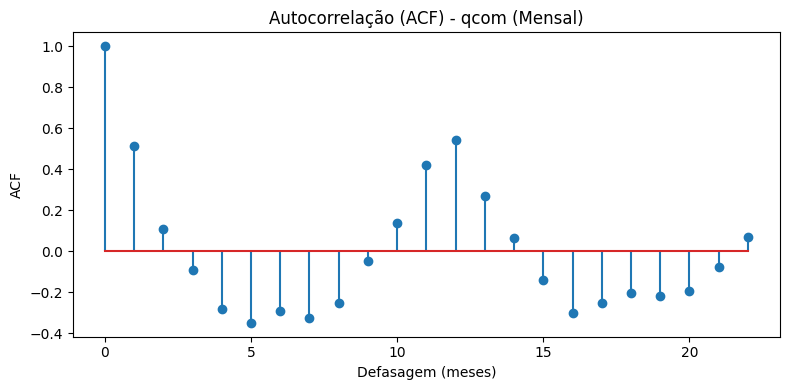

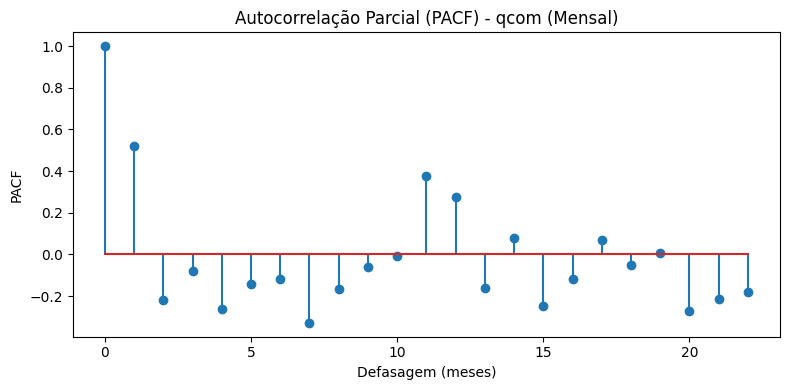

In [86]:
# ACF e PACF
max_lag = min(36, max(5, int(len(ts)/3)))
acf_vals = acf(ts, nlags=max_lag, fft=True, missing="drop")
pacf_vals = pacf(ts, nlags=max_lag, method="yw", alpha=None)

plt.figure(figsize=(8,4))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelação (ACF) - qcom (Mensal)")
plt.xlabel("Defasagem (meses)")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.stem(range(len(pacf_vals)), pacf_vals)
plt.title("Autocorrelação Parcial (PACF) - qcom (Mensal)")
plt.xlabel("Defasagem (meses)")
plt.ylabel("PACF")
plt.tight_layout()
plt.show()

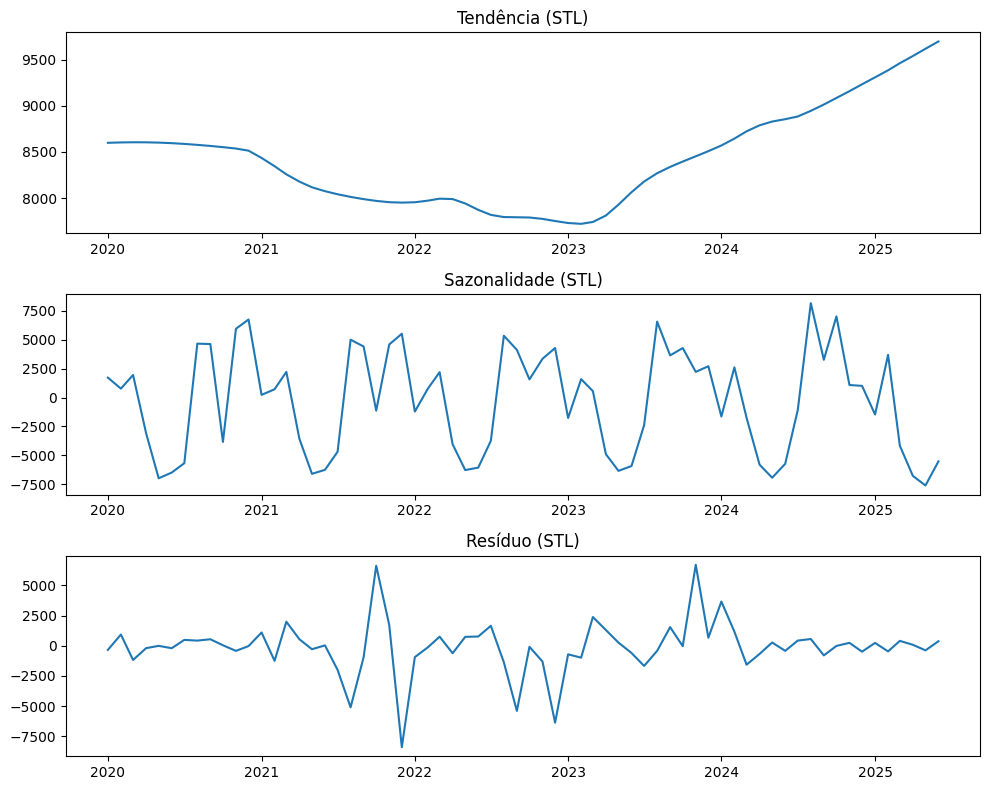

In [88]:
df_m = (
    df.dropna(subset=["data"])
      .set_index("data")
      .sort_index()
      .resample("MS")
      .agg({"qcom":"sum"})
)

# Série de qcom
ts = df_m["qcom"].fillna(0)

# STL
stl = STL(ts, period=12, robust=True).fit()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(311); ax1.plot(stl.trend.index, stl.trend.values); ax1.set_title("Tendência (STL)")
ax2 = fig.add_subplot(312); ax2.plot(stl.seasonal.index, stl.seasonal.values); ax2.set_title("Sazonalidade (STL)")
ax3 = fig.add_subplot(313); ax3.plot(stl.resid.index, stl.resid.values); ax3.set_title("Resíduo (STL)")
fig.tight_layout(); plt.show()

# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)

In [90]:
# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)
lj

,lb_stat,lb_pvalue
12,94.068882,8.012059e-15


In [49]:
# Agregação mensal
df["mes_ano"] = df.data.dt.to_period("M")

# "cod_ibge", " "codfil", "cod"
df_m = df.groupby(["cod_ibge", "mes_ano", "codfil"]).agg(
    quant_vendida = ("qcom", "sum"),
    valor_custeio = ("VlCusteio", "mean"),
    area_custeio = ("AreCusteio", "mean"),
    preco_feijao = ("preco_feijao", "mean"),
    preco_laranja = ("preco_laranja", "mean"),
    preco_trigo = ("preco_trigo", "mean"),
    preco_soja = ("preco_soja", "mean"),
    preco_milho = ("preco_milho", "mean")
).reset_index().set_index("mes_ano").sort_index()


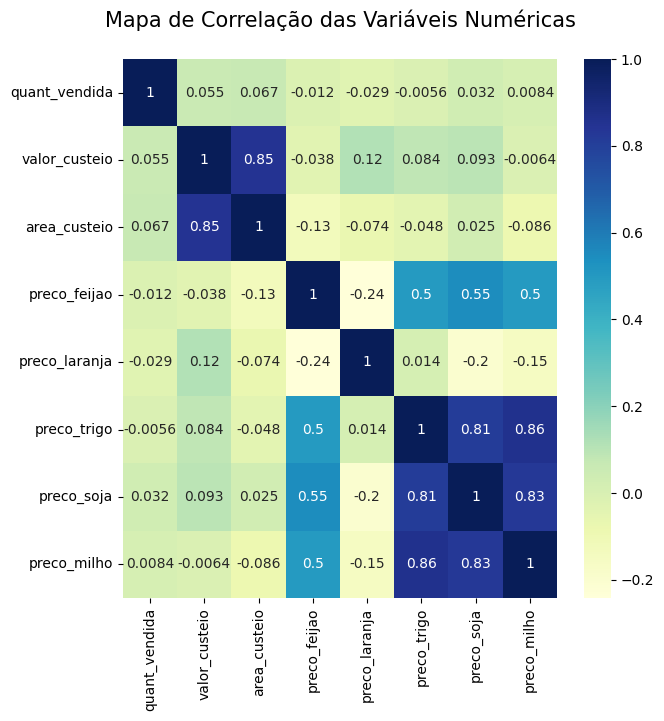

In [50]:
df_m.drop(["cod_ibge", "codfil"], axis=1).corr("spearman")

# Heatmap
plt.figure(figsize = (7, 7))
sns.heatmap(df_m.drop(["cod_ibge", "codfil"], axis=1).corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

## Cluster de filiais

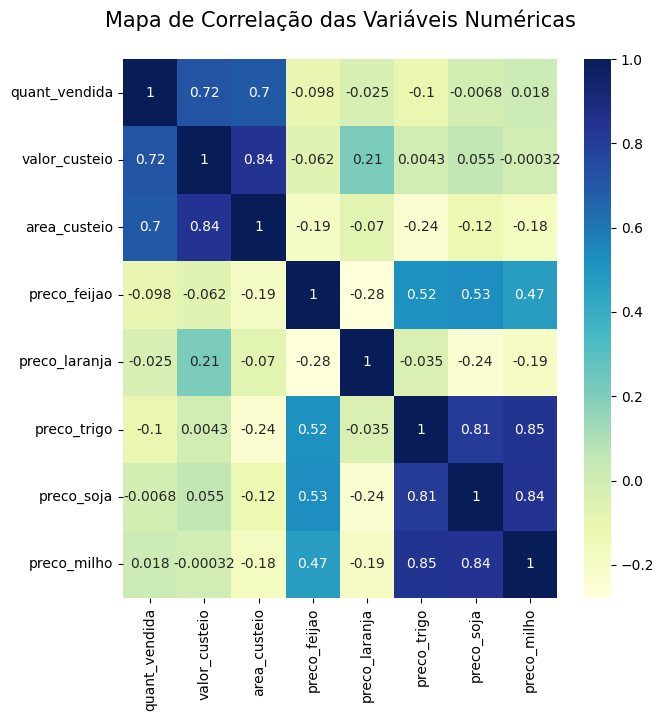

In [67]:
cluster_venda = df.groupby(["cluster", "mes_ano"]).agg(
    quant_vendida = ("qcom", "sum")
).reset_index()

colunas = ["cod_ibge", "mes_ano", "cluster", "VlCusteio", "AreCusteio", 
'preco_feijao', 'preco_laranja', 'preco_trigo', 'preco_soja', 'preco_milho']
df_cluster =  df[colunas].drop_duplicates()

df_cluster = df_cluster.groupby(["cluster", "mes_ano"]).agg(
    valor_custeio = ("VlCusteio", "sum"),
    area_custeio = ("AreCusteio", "sum"),
    preco_feijao = ("preco_feijao", "mean"),
    preco_laranja = ("preco_laranja", "mean"),
    preco_trigo = ("preco_trigo", "mean"),
    preco_soja = ("preco_soja", "mean"),
    preco_milho = ("preco_milho", "mean")
).reset_index()

df_cluster = cluster_venda.merge(df_cluster, on=["cluster", "mes_ano"], how="left")
df_cluster

# Heatmap
plt.figure(figsize = (7, 7))
sns.heatmap(df_cluster.drop(["cluster", "mes_ano"], axis=1).corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

## Cluster produtos

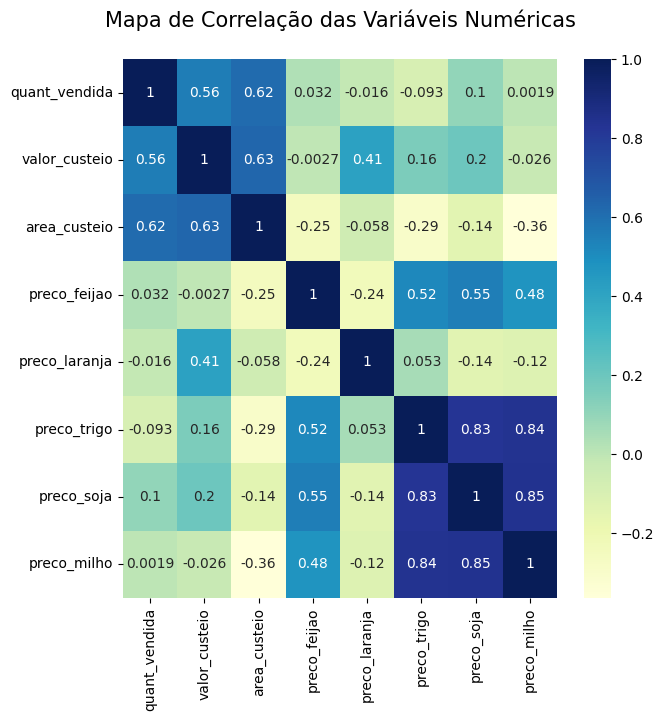

In [66]:
cluster_venda = df.groupby(["cluster_cod", "mes_ano"]).agg(
    quant_vendida = ("qcom", "sum")
).reset_index()

colunas = ["cod_ibge", "mes_ano", "cluster_cod", "VlCusteio", "AreCusteio", 
'preco_feijao', 'preco_laranja', 'preco_trigo', 'preco_soja', 'preco_milho']
df_cluster =  df[colunas].drop_duplicates()

df_cluster = df_cluster.groupby([ "cluster_cod", "mes_ano"]).agg(
    valor_custeio = ("VlCusteio", "sum"),
    area_custeio = ("AreCusteio", "sum"),
    preco_feijao = ("preco_feijao", "mean"),
    preco_laranja = ("preco_laranja", "mean"),
    preco_trigo = ("preco_trigo", "mean"),
    preco_soja = ("preco_soja", "mean"),
    preco_milho = ("preco_milho", "mean")
).reset_index()

df_cluster = cluster_venda.merge(df_cluster, on=["cluster_cod", "mes_ano"], how="left")
df_cluster

# Heatmap
plt.figure(figsize = (7, 7))
sns.heatmap(df_cluster.drop(["cluster_cod", "mes_ano"], axis=1).corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

## Cluster Filiais com Ajuste Sazonal

In [68]:
df_cluster.columns

Index(['cluster', 'mes_ano', 'quant_vendida', 'valor_custeio', 'area_custeio',
       'preco_feijao', 'preco_laranja', 'preco_trigo', 'preco_soja',
       'preco_milho'],
      dtype='object')

In [70]:
# set and sort index
df_cluster.set_index("mes_ano").sort_index()

# Série principal
q = df_cluster["quant_vendida"]

# Ajuste sazonal de q (remover componente sazonal para  evitar correlação espúrias)
q_stl = STL(q, period=12, robust=True).fit()
q_sa = q - q_stl.seasonal

In [77]:
df_cluster.columns

Index(['cluster', 'mes_ano', 'quant_vendida', 'valor_custeio', 'area_custeio',
       'preco_feijao', 'preco_laranja', 'preco_trigo', 'preco_soja',
       'preco_milho'],
      dtype='object')

In [79]:
[c for c in colunas if c in df.columns]

['preco_feijao', 'preco_laranja', 'preco_trigo', 'preco_soja', 'preco_milho']

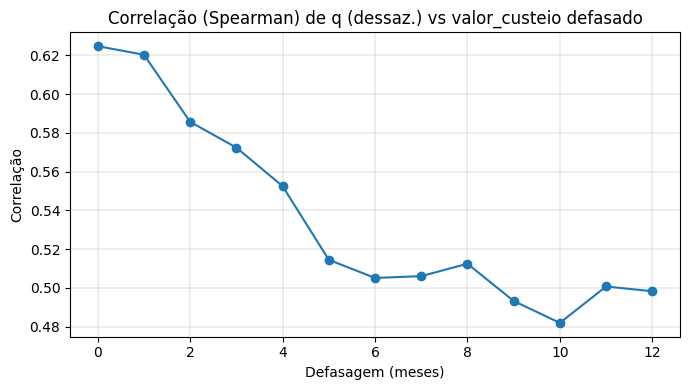

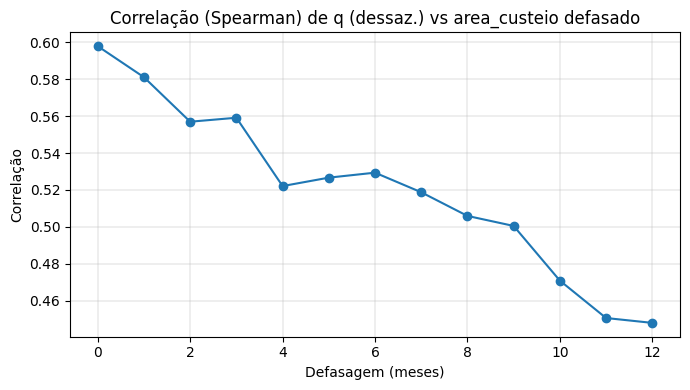

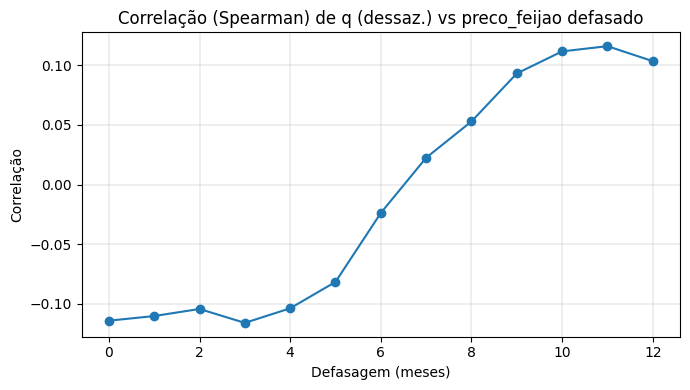

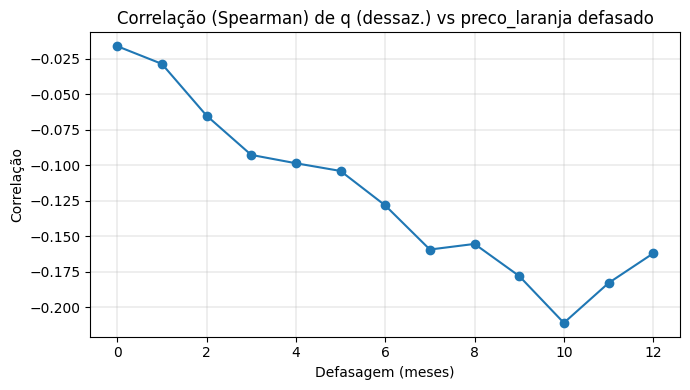

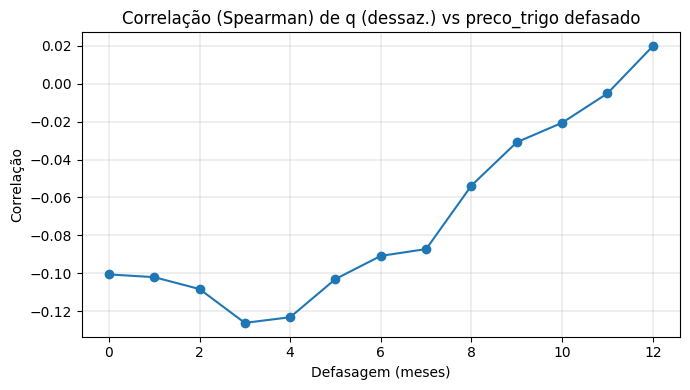

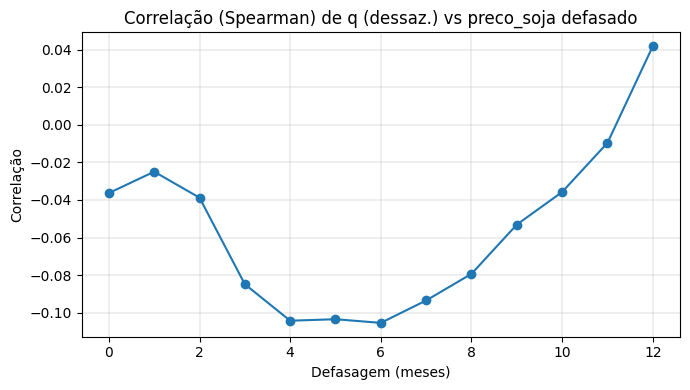

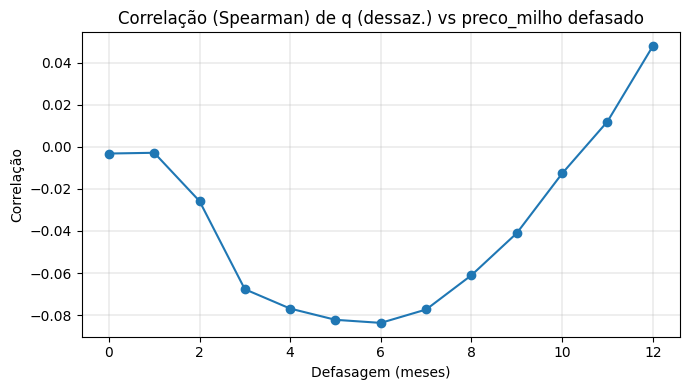

'OK'

In [81]:
colunas = ["valor_custeio","area_custeio","preco_feijao","preco_laranja","preco_trigo","preco_soja","preco_milho"]
price_cols = [c for c in colunas if c in df_cluster.columns]

# ===== Função para correlação com defasagens =====
def lag_corr_table(y, x, max_lag=12, name="x"):
    rows = []
    for k in range(0, max_lag+1):
        # x defasado: preço passado impacta y atual
        x_lag = x.shift(k)
        aligned = pd.concat([y, x_lag], axis=1, keys=["y","xlag"]).dropna()
        if len(aligned) >= 3:
            rows.append({
                "Lag (meses)": k,
                "Pearson": aligned["y"].corr(aligned["xlag"], method="pearson"),
                "Spearman": aligned["y"].corr(aligned["xlag"], method="spearman"),
                "N": len(aligned)
            })
        else:
            rows.append({"Lag (meses)": k, "Pearson": np.nan, "Spearman": np.nan, "N": len(aligned)})
    out = pd.DataFrame(rows)
    out.insert(0, "Variável de preço", name)
    return out

# 1) Tabelas globais (série agregada) — com q e q dessazonalizado
tables_raw = []
tables_sa  = []
for pc in price_cols:
    tables_raw.append(lag_corr_table(q, df_cluster[pc].astype(float), max_lag=12, name=pc))
    tables_sa.append(lag_corr_table(q_sa, df_cluster[pc].astype(float), max_lag=12, name=pc))

tbl_raw = pd.concat(tables_raw, ignore_index=True) if tables_raw else pd.DataFrame()
tbl_sa  = pd.concat(tables_sa,  ignore_index=True) if tables_sa  else pd.DataFrame()

# 2) Por commodity (mapeando xprod -> preço correspondente) e agregando mensalmente
def commodity_of(x):
    if not isinstance(x, str):
        return None
    s = x.lower()
    if "soja" in s: return "soja"
    if "milho" in s: return "milho"
    if "feij" in s: return "feijao"
    if "trigo" in s: return "trigo"
    if "laranj" in s or "suco" in s: return "laranja"
    return None

df["_commodity"] = df["xprod"].apply(commodity_of) if "xprod" in df.columns else None
price_map = {"custeio":"valor_custeio","area":"area_custeio","feijao":"preco_feijao","laranja":"preco_laranja","trigo":"preco_trigo","soja":"preco_soja","milho":"preco_milho"}

rows_comm_raw, rows_comm_sa = [], []
if df["_commodity"].notna().any():
    base = df.dropna(subset=["data"]).copy()
    base["data_m"] = base["data"].values.astype("datetime64[M]")
    for comm, pcol in price_map.items():
        if pcol not in df.columns: 
            continue
        g = (base[base["_commodity"]==comm]
             .groupby("data_m", as_index=True)
             .agg(qcom=("qcom","sum"))
             .sort_index())
        if g.empty: 
            continue
        # preços mensais correspondentes
        pm = (base.groupby("data_m", as_index=True)[pcol].mean()).to_frame("preco")
        gm = g.join(pm, how="inner")
        if gm.empty or gm["preco"].notna().sum() < 3:
            continue
        # dessazonalizar q por commodity
        try:
            gm_stl = STL(gm["qcom"].astype(float).fillna(0), period=12, robust=True).fit()
            gm_sa = gm["qcom"] - gm_stl.seasonal
        except Exception:
            gm_sa = gm["qcom"]
        # tabelas de defasagem
        tab_r = lag_corr_table(gm["qcom"].astype(float), gm["preco"].astype(float), max_lag=6, name=f"{comm} (preço)")
        tab_sa = lag_corr_table(gm_sa.astype(float), gm["preco"].astype(float), max_lag=6, name=f"{comm} (preço)")
        tab_r.insert(0, "Commodity", comm)
        tab_sa.insert(0, "Commodity", comm)
        rows_comm_raw.append(tab_r)
        rows_comm_sa.append(tab_sa)

# 3) Visual: curvas de correlação x lag, por preço (agregado)
if price_cols:
    for pc in price_cols:
        sub = tbl_sa[tbl_sa["Variável de preço"]==pc] if not tbl_sa.empty else tbl_raw[tbl_raw["Variável de preço"]==pc]
        if sub is not None and not sub.empty:
            plt.figure(figsize=(7,4))
            plt.plot(sub["Lag (meses)"], sub["Spearman"], marker="o")
            plt.title(f"Correlação (Spearman) de q (dessaz.) vs {pc} defasado")
            plt.xlabel("Defasagem (meses)")
            plt.ylabel("Correlação")
            plt.grid(True, linewidth=0.3)
            plt.tight_layout()
            plt.show()

"OK"